In [23]:
# Rewriting the code to include regular expressions and other fixes

import os
from pathlib import Path
import re
from collections import defaultdict
import pandas as pd
import gzip
from matplotlib.animation import FuncAnimation

def pair_files_in_folder(folder_path):
    # Initialize a defaultdict to hold the file groups
    file_groups = defaultdict(list)
    
    # Define the regular expressions for locust and environment files
    locust_re = r"VR(\d+)"
    environment_re = r"SimulatedLocustsVR(\d+)"
    
    # Loop through all files in the directory
    for filename in os.listdir(folder_path):
        locust_match = re.search(locust_re, filename)
        environment_match = re.search(environment_re, filename)
        
        if locust_match:
            vr_number = locust_match.groups()[0]
            file_groups[vr_number].append({'type': 'locust', 'filename': filename})
            
        if environment_match:
            vr_number = environment_match.groups()[0]
            file_groups[vr_number].append({'type': 'environment', 'filename': filename})

    return file_groups





In [14]:
# Sample folder path for demonstration; replace with the actual path in your setup
sample_folder_path = '/Users/apaula/src/VRDataAnalysis/SimulatedLocustSwarm/data/20230915rundata/RunData/20230914202153/'

pair_files_in_folder(sample_folder_path)

defaultdict(list,
            {'2': [{'type': 'locust',
               'filename': 'SimulatedLocustData_SimulatedLocustsVR2_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'},
              {'type': 'environment',
               'filename': 'SimulatedLocustData_SimulatedLocustsVR2_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'},
              {'type': 'locust',
               'filename': '2023-09-14_20-21-53_VR2_.csv.gz'}],
             '3': [{'type': 'locust',
               'filename': '2023-09-14_20-21-53_VR3_.csv.gz'},
              {'type': 'locust',
               'filename': 'SimulatedLocustData_SimulatedLocustsVR3_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'},
              {'type': 'environment',
               'filename': 'SimulatedLocustData_SimulatedLocustsVR3_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'}],
             '1': [{'type': 'locust',
               'filename': 'SimulatedLocustData_SimulatedLocustsVR1_50_100_0_0_3_2023-09-14_20-21-53.csv.gz'},
              {'type': 'environment',
     

In [15]:
# Function to load and clean data
def load_and_clean_data(file_path):
    with gzip.open(file_path, 'rb') as f:
        df = pd.read_csv(f)
    # Removing the first row
    df = df.iloc[1:]
    return df

def prepare_data_from_pairs(folder_path):
    file_groups = pair_files_in_folder(folder_path)
    prepared_data = {}
    
    # Loop through the file pairs
    for key, files in file_groups.items():
        locust_file = None
        environment_file = None
        
        # Identify locust and environment files
        for file_info in files:
            if file_info['type'] == 'locust':
                locust_file = file_info['filename']
            elif file_info['type'] == 'environment':
                environment_file = file_info['filename']
                
        # Only proceed if both files are present
        if locust_file and environment_file:
            # Read the CSV files into Pandas dataframes
            with gzip.open(f"{folder_path}/{locust_file}", 'rb') as f:
                locust_df = pd.read_csv(f)
            with gzip.open(f"{folder_path}/{environment_file}", 'rb') as f:
                environment_df = pd.read_csv(f)
            
            # Drop the first row from both dataframes
            locust_df = locust_df.iloc[1:]
            environment_df = environment_df.iloc[1:]
            
            # Store the prepared dataframes
            prepared_data[key] = {'locust': locust_df, 'environment': environment_df}
    
    return prepared_data

# Example usage
prepared_data = prepare_data_from_pairs(sample_folder_path)


In [20]:
prepared_data['1']['locust'].head()


,Current Time,VR,Scene,SensPosX,SensPosY,SensPosZ,SensRotX,SensRotY,SensRotZ,InsectPosX,InsectPosY,InsectPosZ,InsectRotX,InsectRotY,InsectRotZ
1,2023-09-14 20:21:53.212,VR1,SimulatedLocusts,5.186223,-4.546055,0,0,22.81879,0,-4.546055,0,5.186223,0,22.81879,0
2,2023-09-14 20:21:53.229,VR1,SimulatedLocusts,5.185597,-4.551668,0,0,22.85828,0,-4.551668,0,5.185597,0,22.85828,0
3,2023-09-14 20:21:53.247,VR1,SimulatedLocusts,5.212921,-4.553731,0,0,23.02380,0,-4.553731,0,5.212921,0,23.02380,0
4,2023-09-14 20:21:53.262,VR1,SimulatedLocusts,5.222002,-4.544352,0,0,22.29739,0,-4.544352,0,5.222002,0,22.29739,0
5,2023-09-14 20:21:53.279,VR1,SimulatedLocusts,5.226415,-4.534635,0,0,21.07286,0,-4.534635,0,5.226415,0,21.07286,0


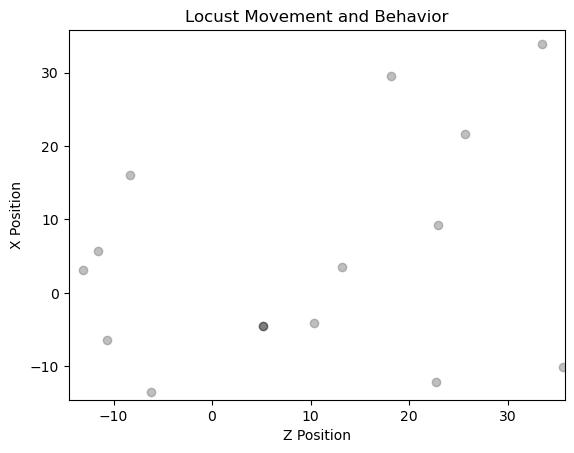

In [30]:
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Your find_closest_timestamp function
def find_closest_timestamp(real_timestamp, simulated_timestamps):
    distances = np.abs(pd.to_datetime(simulated_timestamps) - pd.to_datetime(real_timestamp))
    closest_time = simulated_timestamps.loc[distances.idxmin()]
    closest_rows = simulated_timestamps[simulated_timestamps == closest_time]
    return closest_rows.index

def animate(i, locust_df, environment_df, sc_real, sc_sim):
    real_data = locust_df.iloc[:i*3+1]
    x_real = real_data['InsectPosZ']
    z_real = real_data['InsectPosX']
    sc_real.set_offsets(np.c_[x_real, z_real])
    
    real_timestamp = real_data['Current Time'].iloc[-1]
    closest_index = find_closest_timestamp(real_timestamp, environment_df['Timestamp'])
    sim_data = environment_df.iloc[closest_index]
    x_sim = sim_data['Z']
    z_sim = sim_data['X']
    sc_sim.set_offsets(np.c_[x_sim, z_sim])


# Create the plot
fig, ax = plt.subplots()

# Initialize scatter plots
sc_real = ax.scatter([], [], c= 'black', alpha=0.5, label='Real')
sc_sim = ax.scatter([], [], c='gray', alpha=0.5, label='Simulated')

# Set labels, title, and axis limits
ax.set_xlabel('Z Position')
ax.set_ylabel('X Position')
ax.set_title('Locust Movement and Behavior')
x_min, x_max = prepared_data['1']['locust']['InsectPosX'].min(), prepared_data['1']['locust']['InsectPosX'].max()
z_min, z_max = prepared_data['1']['locust']['InsectPosZ'].min(), prepared_data['1']['locust']['InsectPosZ'].max()
ax.set_xlim(min(z_min, x_min)-10, max(z_max, x_max)+10)
ax.set_ylim(min(z_min, x_min)-10, max(z_max, x_max)+10)

# Create the animation
ani = FuncAnimation(fig, lambda i: animate(i, prepared_data['1']['locust'], prepared_data['1']['environment'], sc_real, sc_sim), frames=(len(prepared_data['1']['locust'])//3), interval=50)

# Create a writer object
writer = FFMpegWriter(fps=20)

# Save the animation
ani.save("locust_behavior_with_environment.mp4", writer=writer)
